## Homework 05:

## Due Date: Mar 09, 2020, 10:00am

#### Firstname Lastname: Chengwei Chen

#### E-mail: cc6576@nyu.edu

#### Enter your solutions and submit this notebook

---

### Part of Lecture 04

---

In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G

# def set_boundary_grid(G):
#     '''set the boundary values'''
#     n = G.shape[0]
#     G[:, 0]  = np.ones((1, n))
#     G[0, : ] = np.ones((1, n)) 
#     G[-1, :] = np.ones((1, n))
#     G[:, -1] = np.ones((1, n))
    
# in this assignment we will consider real matrices;
# hence we use the following function instead
# to assign the boundary values for G
def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:,  0] = [1.0] * n
    G[0,  :] = [1.0] * n
    G[-1, :] = [1.0] * n
    G[:, -1] = [1.0] * n 

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()

# using iterators to traverse the grid
def iteration_gen(G):
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
    

# using numpy built-in functions to compute the error
def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

# deep copy of G1 to G2
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]

    
def solve_heat_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_gen(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

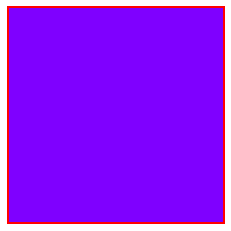

In [2]:
size_of_grid = 100
G = build_grid(n=size_of_grid)
set_boundary_grid(G)
plot_grid(G) 

In [3]:
%load_ext line_profiler
%lprun -f solve_heat_equation4 G4 = solve_heat_equation4(size_of_grid)

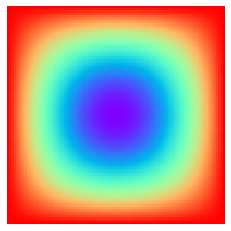

In [4]:
plot_grid(G4)


---

# Problem 1. (100 points)


In Lecture 04 we considered the heat equation over a homogeneous material for which an iteration is given by the following equation:
$$
f_{i,j} = \frac{f_{i+1,j}+f_{i-1,j} + f_{i,j+1} + f_{i,j-1}}{4} \,.
$$

This was implemented by: 
```
# using iterators to traverse the grid
def iteration_gen(G):
"""the iteration function from lect04"""
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
```


----

Now imagine, you are given a non-homogeneous material for which the iteration, i.e. the corresponding equation,  depends on the position $(i, j)$ and is given by:
$$
f_{i,j} := \frac{ h_{i + 1,j} f_{i + 1, j} + h_{i - 1,j} f_{i - 1,j} + h_{i,j + 1} f_{i,j+1} + h_{i,j - 1} f_{i,j-1}}{ h_{i + 1,j} + h_{i - 1,j} + h_{i,j + 1} + h_{i,j - 1} } \,.
$$
Here "weight"
$$h(i, j) = \exp\left(-\frac{|i - j|} {\sqrt{n}}\right) \,,$$
corresponds to the point $(i, j)$, where $n$ is the size of the grid.

----

Write a new function:
```
def iteration_gen_nonhomogeneous(G):
    """the iteration function in hw05"""
```
to solve the non-homogeneous case defined as above. 


The task here is to examine run-time improvements that can be obtained by Cython for this non-homogeneous material. Consider **solve_heat_equation4** from Lect04, which now becomes.

```
def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)
```

----

Concretely, as presented in Lect05, perform the following steps and measure their run-times:

(i) simply compile the python code with Cython, without any changes;


(ii) introduce variables and arrays with ctypes (by using the command cdef);  


(iii) besides (ii), also use the content of ndarray objects in order to efficiently access the data buffer of the arrays.

---

In the sequel of the notebook, as your solution, submit codes, run-times, and plots of the following tasks:

**2.1 (30pt)** solve_heat_nonhomogeneous_equation4(100)

**2.2 (10pt)** solve_heat_nonhomogeneous_equation4(100) when applied (i)  

**2.3 (30pt)** solve_heat_nonhomogeneous_equation4(100) when applied (ii)  

**2.4 (30pt)** solve_heat_nonhomogeneous_equation4(100) when applied (iii)  

Notice that to obtain a best performance for the heat equation you also need to apply (i), (ii), (iii) to the functions called within "solve_heat_equation4".


In [2]:
%load_ext Cython

In [3]:
%load_ext line_profiler

In [4]:
size_of_grid = 100

### Part 1: solve_heat_equation4(100)

In [5]:
def iteration_gen_nonhomogeneous(G):
    """the iteration function in hw05"""
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        i = e[0]
        j = e[1]
        h_1 = np.exp(-np.abs(i+1-j)/np.sqrt(n))
        h_2 = np.exp(-np.abs(i-1-j)/np.sqrt(n))
        h_3 = np.exp(-np.abs(i-(j+1))/np.sqrt(n))
        h_4 = np.exp(-np.abs(i-(j-1))/np.sqrt(n))
        G[e] = (h_1*G[i+1, j] + h_2*G[i-1, j] + h_3*G[i, j+1] + h_4*G[i, j-1])/(h_1+h_2+h_3+h_4)


In [6]:
def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)

    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

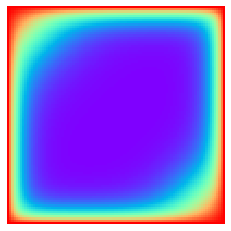

In [7]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### Part 2: solve_heat_equation4(100) after applying (i)


In [8]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [9]:
%%cython 
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1
# cython: profile=True

from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G
    
def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:,  0] = [1.0] * n
    G[0,  :] = [1.0] * n
    G[-1, :] = [1.0] * n
    G[:, -1] = [1.0] * n 

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()

def iteration_gen_nonhomogeneous(G):
    """the iteration function in hw05"""
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        i = e[0]
        j = e[1]
        h_1 = np.exp(-np.abs(i+1-j)/np.sqrt(n))
        h_2 = np.exp(-np.abs(i-1-j)/np.sqrt(n))
        h_3 = np.exp(-np.abs(i-(j+1))/np.sqrt(n))
        h_4 = np.exp(-np.abs(i-(j-1))/np.sqrt(n))
        G[e] = (h_1*G[i+1, j] + h_2*G[i-1, j] + h_3*G[i, j+1] + h_4*G[i, j-1])/(h_1+h_2+h_3+h_4)

def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

def copy_array(G1, G2):
    G2[:, :] = G1[:, :]

def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)

    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

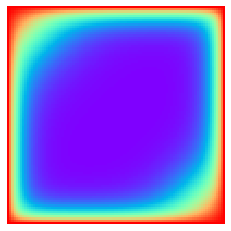

In [10]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### Part 3: solve_heat_equation4(100) after applying (ii)

In [11]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [12]:
%%cython 
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1
# cython: profile=True

from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G
    
def set_boundary_grid(G):
    '''set the boundary values'''
    cdef int n = G.shape[0]
    G[:,  0] = [1.0] * n
    G[0,  :] = [1.0] * n
    G[-1, :] = [1.0] * n
    G[:, -1] = [1.0] * n 

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()


def iteration_gen_nonhomogeneous(G):
    """the iteration function in hw05"""
    cdef int n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    cdef int i
    cdef int j
    cdef double h_1, h_2, h_3, h_4
    for e in indices:
        i = e[0]
        j = e[1]
        h_1 = np.exp(-np.abs(i+1-j)/np.sqrt(n))
        h_2 = np.exp(-np.abs(i-1-j)/np.sqrt(n))
        h_3 = np.exp(-np.abs(i-(j+1))/np.sqrt(n))
        h_4 = np.exp(-np.abs(i-(j-1))/np.sqrt(n))
        G[e] = (h_1*G[i+1, j] + h_2*G[i-1, j] + h_3*G[i, j+1] + h_4*G[i, j-1])/(h_1+h_2+h_3+h_4)


def calc_error_np(G1, G2):
    cdef double error = np.square(np.subtract(G1, G2)).mean()
    return(error)

def copy_array(G1, G2):
    G2[:, :] = G1[:, :]

def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)

    G_prev = build_grid(n)
    copy_array(G, G_prev)

    cdef float error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

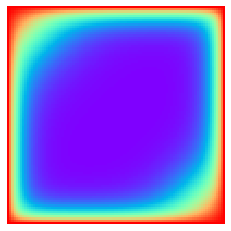

In [13]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### Part 4: solve_heat_equation4(100) after applying (iii)

In [14]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [15]:
%%cython 
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1
# cython: profile=True

from itertools import product
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt

def build_grid(n):
    '''defines the grid'''
    cdef np.ndarray G = np.zeros((n, n))
    return G
    
def set_boundary_grid(np.ndarray G):
    '''set the boundary values'''
    cdef int n = G.shape[0]
    G[:,  0] = [1.0] * n
    G[0,  :] = [1.0] * n
    G[-1, :] = [1.0] * n
    G[:, -1] = [1.0] * n 

def plot_grid(np.ndarray G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()


def iteration_gen_nonhomogeneous(np.ndarray G):
    """the iteration function in hw05"""
    cdef int n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    cdef int i
    cdef int j
    cdef double h_1, h_2, h_3, h_4
    for e in indices:
        i = e[0]
        j = e[1]
        h_1 = np.exp(-np.abs(i+1-j)/np.sqrt(n))
        h_2 = np.exp(-np.abs(i-1-j)/np.sqrt(n))
        h_3 = np.exp(-np.abs(i-(j+1))/np.sqrt(n))
        h_4 = np.exp(-np.abs(i-(j-1))/np.sqrt(n))
        G[e] = (h_1*G[i+1, j] + h_2*G[i-1, j] + h_3*G[i, j+1] + h_4*G[i, j-1])/(h_1+h_2+h_3+h_4)

def calc_error_np(np.ndarray G1, np.ndarray G2):
    cdef double error = np.square(np.subtract(G1, G2)).mean()
    return(error)

def copy_array(np.ndarray G1, np.ndarray G2):
    G2[:, :] = G1[:, :]

def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)

    G_prev = build_grid(n)
    copy_array(G, G_prev)

    cdef float error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

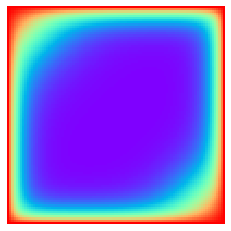

In [16]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)